This notebook is targeted at finding the optimum time of travelling between two stations. We extracted some locational data from a github repository https://github.com/naomistuart/sydneytrains. We simplified the train problem so that only one connection between 2 neighbouring stations was made and didn't account for live data, train boarding times or delays. We generated our data to also include services that would occasionally skip multiple stations. These lines are expected to be chosen as the optimum path unless another route is found. This notebook will use Breadth First Search techniques (tree and graph) to determine the optimum route between two stations. 

---

Run these code blocks if you are running this on google collab. If you are running this on a local notebook, ignore this section. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


This should change the folder which this program can access. 


In [ ]:
cd drive/MyDrive/Stuti\ -\ BFS

/content/drive/MyDrive/Stuti - BFS


Make sure that all BFS python scripts and heading_v3.py and utils.py are accessible form this notebook. 


In [ ]:
ls

'Assignment 1 Trains Problem - BFS'   BFS_tree.py       __pycache__/
 BFS_graph_for_graph.py               Data/             utils.py
 BFS_graph.py                         graphProblem.py
 BFS_tree_for_graph.py                heading_v3.py


---
These are all the import statements used for the assignment.

In [ ]:
from heading_v3 import * # Handles most of the graph problem creation and matplotlib WE HAVE ALTERED THIS FILE, PLEASE USE OUR FILE INSTEAD OF THE ORIGINAL HEADING_V3.  
import pandas as pd # Used for most data frame creation. 
import matplotlib.pyplot as plt #Used for ploting and helping with visual outputs. 

Set file locations for the excel spread sheets of interest.


In [ ]:
data_NODES = 'Data/nodeLocations.xlsx' 
data_EDGES = 'Data/TrainPairs.xlsx'

Read both files and store it into a data frame. This way it can be read like a table.

In [ ]:
dfNODES = pd.read_excel(data_NODES) # This variable will store all our station details needed for the nodes in our graph. 
dfNODES.head() # Makes sure that the file is either reachable or readable.

,LocationName,LocationX,LocationY
0,Allawah,15111.454867,-3396.972995
1,Arncliffe,15114.717400,-3393.678246
2,Artarmon,15118.470089,-3380.854241
3,Ashfield,15112.585123,-3388.763777
4,Asquith,15110.820109,-3368.852348


In [ ]:
dfEDGES = pd.read_excel(data_EDGES) # This variable will store all our station connection details for the edges in our graph.
dfEDGES.head() # Makes sure that the file is either reachable or readable.

,City Name,Allawah,Arncliffe,Artarmon,Ashfield,Asquith,Auburn,Banksia,Bankstown,Bardwell Park,...,West Ryde,Westmead,Wiley Park,Windsor,Wolli Creek,Wollstonecraft,Woolooware,Wynyard,Yagoona,Yennora
0,Allawah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Arncliffe,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
2,Artarmon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ashfield,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Asquith,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This code will load the nodes into a list so we can pass it through define_graph() function later on. 


In [ ]:
nodes = []
node = []
name = dfNODES["LocationName"]
location = (dfNODES["LocationX"],dfNODES["LocationY"])

for x1,x2 in zip(dfNODES["LocationName"],zip(dfNODES["LocationX"],dfNODES["LocationY"])):
    node.append(x1)
    node.append(x2)
    nodes.append(node)
    node=[]

Storing the list of lists of edge relationships between the nodes. 

In [ ]:
totalRelations=[] # final list
relations = []
relation = []

for i in range (dfEDGES.shape[0]-1):
    x = dfEDGES.iloc[i,:]
    relationKey=(x[0])
    #print(x)
    for j in range (1,dfEDGES.shape[1]):
        if (j>i and x[j] != 0 ):
            relation.append([dfEDGES.columns[j],x[j]])
    if (len(relation) != 0):
        relations = [relationKey, relation]
        totalRelations.append(relations)

    relation =[]
    relations=[]

We call define_graph(edges, nodes, True) so we can generate an environment for our agent to search. 

In [ ]:
train_graph_data, train_graph = define_graph(totalRelations, nodes, True)

This should show the real map locations of each station and their connections between the nodes. There is a total of 170 stations in our problem. 


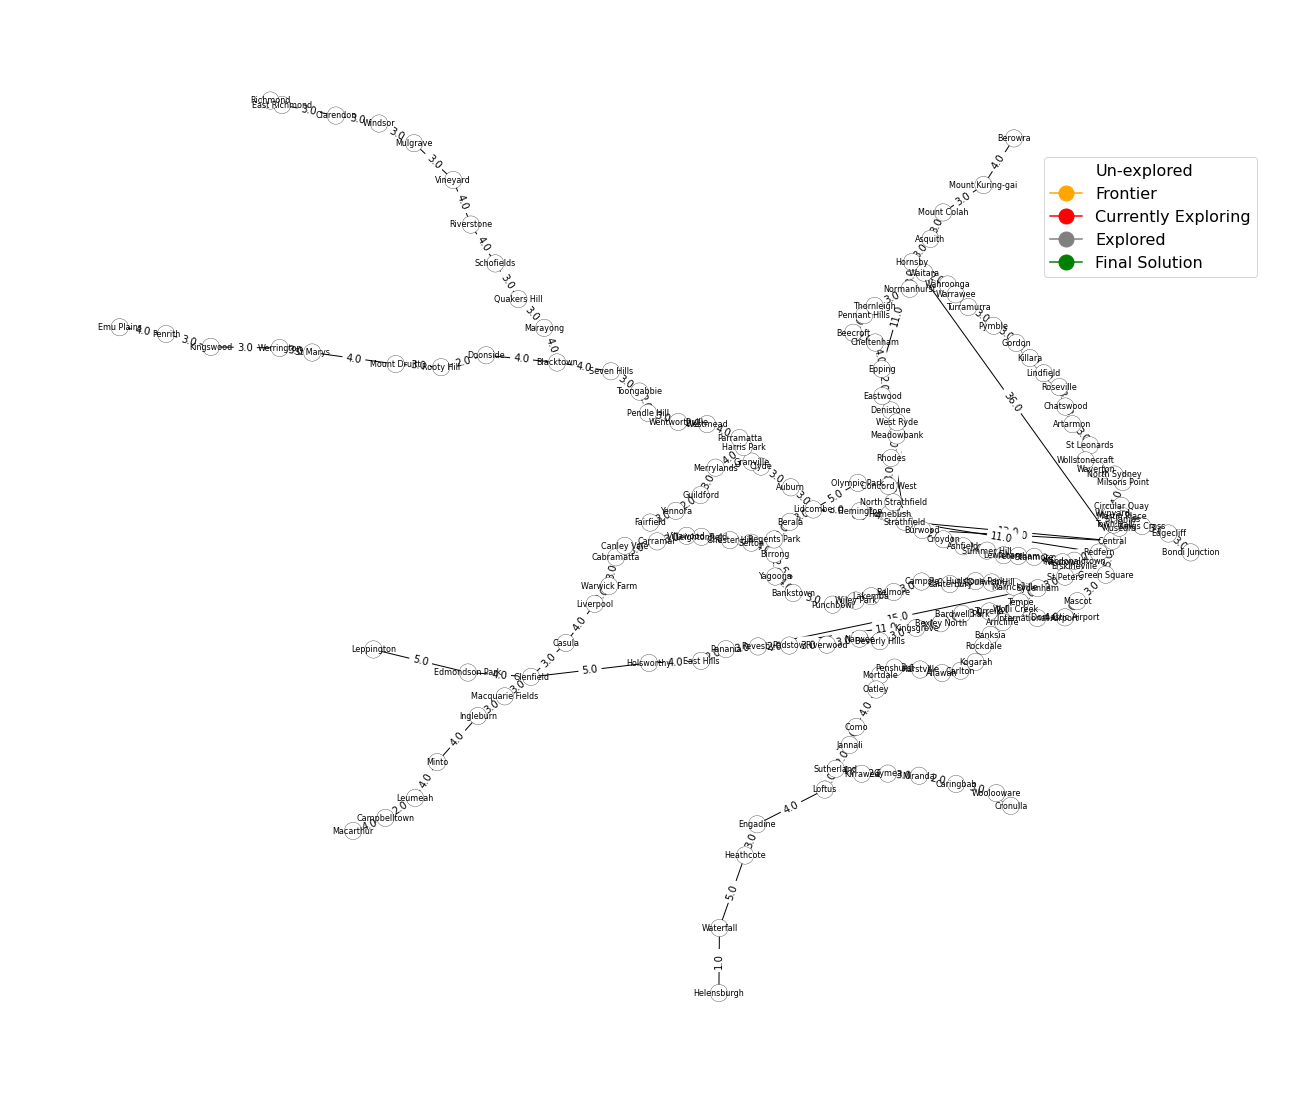

In [ ]:
show_graph(train_graph_data)

This should get user inputs to always match a station otherwise it will prompt the user to try agian. 

In [ ]:
def first_station():
  userinput = input("First Station is: ")
  for item in dfNODES["LocationName"]:
    if userinput.lower() == item.lower():
      return item      
  print(f"Sorry, you typed in {userinput}, have a look again at our station list!")
  return first_station()   

def second_station():
  userinput = input("Second Station is: ")
  for item in dfNODES["LocationName"]:
    if userinput.lower() == item.lower():
      return item
  print(f"Sorry, you typed in {userinput}, have a look again at our station list!")
  return second_station()

`This will create the problem of interest. Here is our list of stations you can choose from:`

**Allawah, Arncliffe, Artarmon, Ashfield, Asquith, Auburn, Banksia, Bankstown, Bardwell Park, Beecroft, Belmore, Berala, Berowra, Beverly Hills, Bexley North, Birrong, Blacktown, Bondi Junction, Burwood, Cabramatta, Campbelltown, Campsie, Canley Vale, Canterbury, Caringbah, Carlton, Carramar, Casula, Central, Chatswood, Cheltenham, Chester Hill, Circular Quay, Clarendon, Clyde, Como, Concord West, Cronulla, Croydon, Denistone, Domestic Airport, Doonside, Dulwich Hill, East Hills, East Richmond, Eastwood, Edgecliff, Edmondson Park, Emu Plains, Engadine, Epping, Erskineville, Fairfield, Flemington, Glenfield, Gordon, Granville, Green Square, Guildford, Gymea, Harris Park, Heathcote, Helensburgh, Holsworthy, Homebush, Hornsby, Hurlstone Park, Hurstville, Ingleburn, International Airport, Jannali, Killara, Kings Cross, Kingsgrove, Kingswood, Kirrawee, Kogarah, Lakemba, Leightonfield, Leppington, Leumeah, Lewisham, Lidcombe, Lindfield, Liverpool, Loftus, Macarthur, Macdonaldtown, Macquarie Fields, Marayong, Marrickville, Martin Place, Mascot, Meadowbank, Merrylands, Milsons Point, Minto, Miranda, Mortdale, Mount Colah, Mount Druitt, Mount Kuring-gai, Mulgrave, Museum, Narwee, Newtown, Normanhurst, North Strathfield, North Sydney, Oatley, Olympic Park, Padstow, Panania, Parramatta, Pendle Hill, Pennant Hills, Penrith, Penshurst, Petersham, Punchbowl, Pymble, Quakers Hill, Redfern, Regents Park, Revesby, Rhodes, Richmond, Riverstone, Riverwood, Rockdale, Rooty Hill, Roseville, Schofields, Sefton, Seven Hills, St James, St Leonards, St Marys, St Peters, Stanmore, Strathfield, Summer Hill, Sutherland, Sydenham, Tempe, Thornleigh, Toongabbie, Town Hall, Turramurra, Turrella, Villawood, Vineyard, Wahroonga, Waitara, Warrawee, Warwick Farm, Waterfall, Waverton, Wentworthville, Werrington, West Ryde, Westmead, Wiley Park, Windsor, Wolli Creek, Wollstonecraft, Woolooware, Wynyard, Yagoona, Yennora**

The code has made it so your inputs don't have to be case sensitive but do make sure spaces are included as they should. 

In [ ]:
trainproblem = GraphProblem(first_station(),second_station(),train_graph)

First Station is: blacktown
Second Station is: padstow


These imports can be used to generate a BFS with a **GRAPH SOLUTION**.

In [ ]:
from BFS_graph import *  # Breadth first search (graph version)
BFS_graph = BFS_graph_algorithm() # rename BFS_graph_algorithm() to BFS_graph
from BFS_graph_for_graph import *
BFS_graph_for_graph = BFS_graph_algorithm_for_graph()

These imports can be used to generate a BFS with a **TREE SOLUTION**

In [ ]:
from BFS_tree import *  # Breadth first search (tree version)
BFS_tree = BFS_tree_algorithm() # rename BFS_tree_algorithm() to BFS_tree
from BFS_tree_for_graph import *
BFS_tree_for_graph = BFS_tree_algorithm_for_graph()

Code to generate a **TEXT** based **GRAPH SOLUTION**


In [ ]:
display_result(trainproblem,BFS_graph())

Algorithm: BFS_graph
 Iteration times : 238  Path : [<Node Blacktown>, <Node Seven Hills>, <Node Toongabbie>, <Node Pendle Hill>, <Node Wentworthville>, <Node Westmead>, <Node Parramatta>, <Node Harris Park>, <Node Granville>, <Node Clyde>, <Node Auburn>, <Node Lidcombe>, <Node Strathfield>, <Node Redfern>, <Node Sydenham>, <Node Revesby>, <Node Padstow>]


Code to generate a **TEXT** based **TREE SOLUTION**

In [ ]:
display_result(trainproblem,BFS_tree())

Algorithm: BFS_tree
 Iteration times : 252619  Path : [<Node St Marys>, <Node Mount Druitt>, <Node Rooty Hill>, <Node Doonside>, <Node Blacktown>, <Node Seven Hills>, <Node Toongabbie>, <Node Pendle Hill>, <Node Wentworthville>, <Node Westmead>, <Node Parramatta>, <Node Harris Park>, <Node Granville>, <Node Clyde>, <Node Auburn>, <Node Lidcombe>]


Running the next code should enable a button "Visualize" This button should be pressed to see the search and its process in finding the above text solution. Followed by the actual solution. 

In [ ]:
display_result_for_graph(trainproblem, BFS_graph_for_graph(), train_graph_data)

Algorithm: BFS_graph_for_graph


interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…



---


Unmount the drive if you are viewing this on google collab


In [ ]:
from google.colab import drive
drive.flush_and_unmount()